In [40]:
 # Importing  basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importing Machine learning
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Others libraries 
import warnings
warnings.filterwarnings('ignore')

# Display options
pd.set_option('display.max_columns', None)
print("Libraries imported successfully")


Libraries imported successfully


In [41]:
#Here we are installing the kagglehub 
!pip install kagglehub[pandas-datasets]


In [55]:
# Set random seed for reproducibility
np.random.seed(42)

# Load the ULB credit card fraud dataset
print("Downloading and loading the ULB credit card fraud dataset...")
try:
    df = kagglehub.load_dataset(
        KaggleDatasetAdapter.PANDAS,
        "mlg-ulb/creditcardfraud",
        "creditcard.csv",
        pandas_kwargs={'encoding': 'latin1'}
    )
    print("Dataset loaded successfully!")
except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Trying alternative method to load the dataset...")
    # Fallback: Download the dataset manually and read with pandas
    dataset_path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
    df = pd.read_csv(f"{dataset_path}/creditcard.csv", encoding='latin1')
    print("Dataset loaded using fallback method!")

#We are loading the dataset is directly from Kaggle so that we don't have to store it on the pc.

Dataset loaded successfully!


In [56]:
# Display first 5 records
print("First 5 records:\n", df.head())

First 5 records:
    Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10       V11       V12       V13       V14  \
0  0.098698  0.363787  0.090794 -0.551600 -0.617801 -0.991390 -0.311169   
1  0.085102 -0.255425 -0.166974  1.612727  1.065235  0.489095 -0.143772   
2  0.247676 -1.514654  0.207643  0.624501  0.066084  0.717293 -0.165946   
3  0.377436 -1.387024 -0.054952 -0.226487  0.178228  0.507757 -0.287924   
4 -0.270533  0.817739  0.753074 -0.822843  0.538196  1.345852 -1.119670   

        V15       V16       V17       V18   

In [57]:
# Data Preprocessing
print("\nPreprocessing the dataset...")
# Check for missing values
if df.isnull().sum().sum() > 0:
    print("Missing values detected. Filling with median...")
    df.fillna(df.median(), inplace=True)


Preprocessing the dataset...


In [58]:
# Separate features and target
X = df.drop(columns=['Class'])
y = df['Class']

# Scale the features (important for anomaly detection algorithms)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training (normal transactions only) and testing sets
X_normal = X_scaled[y == 0]
X_test = X_scaled
y_test = y


In [59]:
# For training, we use only normal transactions (Class == 0)
print("Splitting data: Training with normal transactions, testing with all...")
X_train, _, _, _ = train_test_split(X_normal, X_normal, test_size=0.2, random_state=42)

# Initialize models
iso_forest = IsolationForest(contamination=0.0017, random_state=42)  
oc_svm = OneClassSVM(kernel='rbf', nu=0.0017) 

# Train Isolation Forest
print("\nTraining Isolation Forest...")
iso_forest.fit(X_train)

# Train One-Class SVM
print("Training One-Class SVM...")
oc_svm.fit(X_train)
print("done")

Splitting data: Training with normal transactions, testing with all...

Training Isolation Forest...
Training One-Class SVM...
done


In [60]:
# Predict anomalies on test set
print("\nPredicting anomalies...")
iso_pred = iso_forest.predict(X_test)
oc_svm_pred = oc_svm.predict(X_test)

# Convert predictions: -1 (anomaly) to 1 (fraud), 1 (normal) to 0 (non-fraud)
iso_pred = np.where(iso_pred == -1, 1, 0)
oc_svm_pred = np.where(oc_svm_pred == -1, 1, 0)


Predicting anomalies...


In [61]:
# Evaluate models
print("\nIsolation Forest Performance:")
print(classification_report(y_test, iso_pred, target_names=['Non-Fraud', 'Fraud']))
iso_roc_auc = roc_auc_score(y_test, iso_pred)
print(f"Isolation Forest AUC-ROC: {iso_roc_auc:.4f}")

print("\nOne-Class SVM Performance:")
print(classification_report(y_test, oc_svm_pred, target_names=['Non-Fraud', 'Fraud']))
oc_svm_roc_auc = roc_auc_score(y_test, oc_svm_pred)
print(f"One-Class SVM AUC-ROC: {oc_svm_roc_auc:.4f}")


Isolation Forest Performance:
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00    284315
       Fraud       0.20      0.24      0.22       492

    accuracy                           1.00    284807
   macro avg       0.60      0.62      0.61    284807
weighted avg       1.00      1.00      1.00    284807

Isolation Forest AUC-ROC: 0.6191

One-Class SVM Performance:
              precision    recall  f1-score   support

   Non-Fraud       1.00      0.99      1.00    284315
       Fraud       0.18      0.81      0.30       492

    accuracy                           0.99    284807
   macro avg       0.59      0.90      0.65    284807
weighted avg       1.00      0.99      1.00    284807

One-Class SVM AUC-ROC: 0.9033


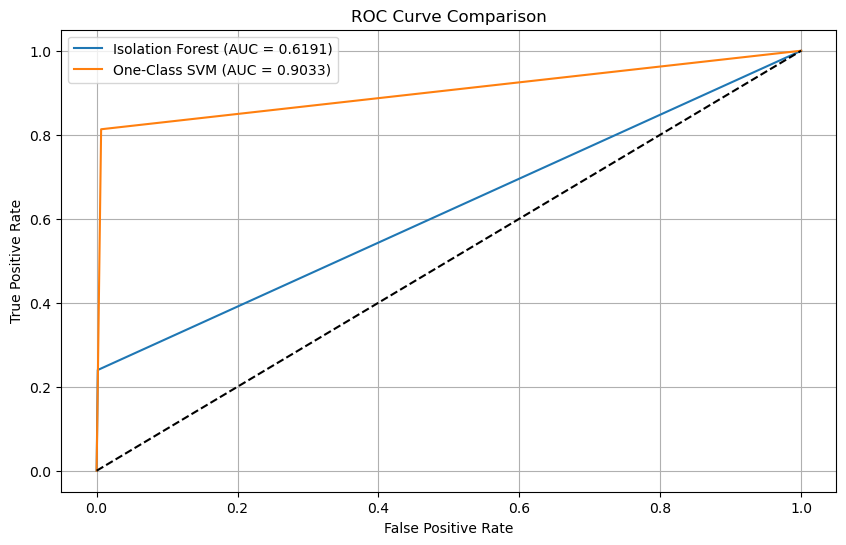

In [62]:
# Plot ROC Curves
plt.figure(figsize=(10, 6))
# Isolation Forest ROC
iso_fpr, iso_tpr, _ = roc_curve(y_test, iso_pred)
plt.plot(iso_fpr, iso_tpr, label=f'Isolation Forest (AUC = {iso_roc_auc:.4f})')
# One-Class SVM ROC
oc_fpr, oc_tpr, _ = roc_curve(y_test, oc_svm_pred)
plt.plot(oc_fpr, oc_tpr, label=f'One-Class SVM (AUC = {oc_svm_roc_auc:.4f})')
# Reference line
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()


In [63]:
# Summary of model comparison
print("\nModel Comparison Summary:")
print(f"Isolation Forest AUC-ROC: {iso_roc_auc:.4f}")
print(f"One-Class SVM AUC-ROC: {oc_svm_roc_auc:.4f}")
if iso_roc_auc > oc_svm_roc_auc:
    print("Isolation Forest outperforms One-Class SVM based on AUC-ROC.")
else:
    print("One-Class SVM outperforms Isolation Forest based on AUC-ROC.")


Model Comparison Summary:
Isolation Forest AUC-ROC: 0.6191
One-Class SVM AUC-ROC: 0.9033
One-Class SVM outperforms Isolation Forest based on AUC-ROC.


Performance Metrics


,Model,Precision,Recall,F1-Score
0,Isolation Forest,0.202401,0.239837,0.219535
1,One-Class SVM,0.180587,0.813008,0.295530


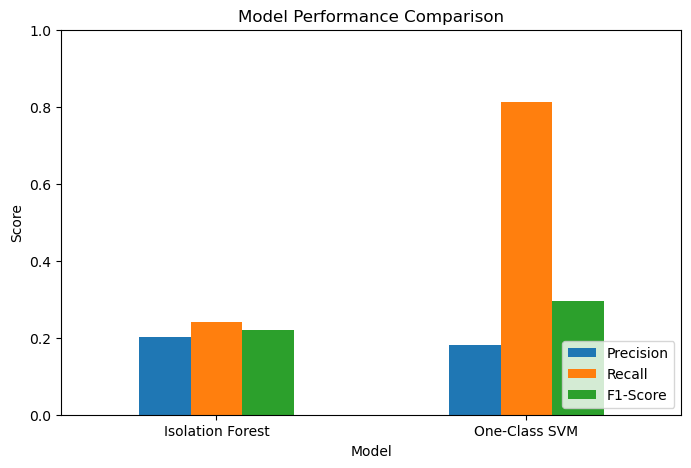

In [64]:
# Performance Comparison Between Models
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate metrics for Isolation Forest
precision_iso = precision_score(y, iso_pred)
recall_iso = recall_score(y, iso_pred)
f1_iso = f1_score(y, iso_pred)

# Calculate metrics for One-Class SVM
precision_svm = precision_score(y, oc_svm_pred)
recall_svm = recall_score(y, oc_svm_pred)
f1_svm = f1_score(y, oc_svm_pred)

# Organize results in a dataframe
performance_df = pd.DataFrame({
    'Model': ['Isolation Forest', 'One-Class SVM'],
    'Precision': [precision_iso, precision_svm],
    'Recall': [recall_iso, recall_svm],
    'F1-Score': [f1_iso, f1_svm]
})

print("Performance Metrics")
display(performance_df)

# Plot the performance
performance_df.set_index('Model', inplace=True)
performance_df.plot(kind='bar', figsize=(8, 5))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()


In [65]:
import joblib
import os

# Create a folder to store models
os.makedirs("saved_models", exist_ok=True)

# Save both trained models
joblib.dump(iso_forest, "saved_models/isolation_forest_model.pkl")
joblib.dump(oc_svm, "saved_models/one_class_svm_model.pkl")
joblib.dump(scaler, "saved_models/feature_scaler.pkl") 

print(" Models and scaler saved successfully in the 'saved_models' folder.")


 Models and scaler saved successfully in the 'saved_models' folder.


In [66]:

# Load models and scaler
iso_forest_loaded = joblib.load("saved_models/isolation_forest_model.pkl")
oc_svm_loaded = joblib.load("saved_models/one_class_svm_model.pkl")
scaler_loaded = joblib.load("saved_models/feature_scaler.pkl")

print("Models and scaler loaded successfully!")

# Example: making a prediction on the first 5 test samples
X_test_scaled = scaler_loaded.transform(df.drop(columns=['Class']))
sample_pred = iso_forest_loaded.predict(X_test_scaled[:5])
sample_pred = np.where(sample_pred == -1, 1, 0)
print("Sample predictions (Isolation Forest):", sample_pred)


Models and scaler loaded successfully!
Sample predictions (Isolation Forest): [0 0 0 0 0]
